In [1]:
### Google Colaboratory only ###
! pip install optuna

     |████████████████████████████████| 266kB 8.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 7.0MB/s 
     |████████████████████████████████| 163kB 16.3MB/s 
     |████████████████████████████████| 112kB 17.2MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 133kB 17.1MB/s 
     |████████████████████████████████| 81kB 8.2MB/s 
  Created wheel for optuna: filename=optuna-2.3.0-cp36-none-any.whl size=359761 sha256=92978d8f1bc477640077cabe8823c3a535e45a173d2fda6a66d19d03f811d72a
  Stored in directory: /root/.cache/pip/wheels/fa/91/19/64b0ec6b964f89c0695a9dc6db6f851d0b54c5381a5c9cadfb
Successfully built optuna
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13700 sha256=509df35871854fefb7867f33e66eb844e2fe0a04eda91bdcdbab88cf14beebce
  Stored in directory: /root/.cache/pip/whe

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy
import lightgbm as lgb
import sklearn.model_selection
import optuna
import statsmodels.api as sm

from scipy.stats import rankdata
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from optuna.integration import lightgbm as lgb_o
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [3]:
### Google Colaboratory only ###
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
### Google Colaboratory only ###
stock_data = pd.read_csv('/content/drive/My Drive/stock_data.csv')

In [ ]:
stock_data = pd.read_csv('stock_data.csv')

In [34]:
stock_data = stock_data.drop('Unnamed: 0', axis=1)

# データの作成

In [35]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data['year'] = stock_data['Date'].dt.year
stock_data['month'] = stock_data['Date'].dt.month

In [36]:
id_list = [9613]
stock_data_9613 = stock_data[stock_data['Id'] == id_list[0]].reset_index(drop=True)

In [37]:
# logリターン
# 確認済み
def make_log_return(_stock_data_, return_days=[2, 5, 25, 50, 75]):
  for num in return_days:
    log_return = [None for i in range(1, num)]
    for i in range(len(_stock_data_) - (num - 1)):
      log_return.append(np.log(_stock_data_['Close'][i + (num - 1)] / _stock_data_['Close'][i]))
    _stock_data_['log_return_' + str(num)] = log_return
    
make_log_return(stock_data_9613)

In [38]:
# DMI
# 確認済み
def make_dmi(_stock_data_, di_days=14, adx_days=14):
    plus_dm = [None]
    minus_dm = [None]
    tr_list = [None]
    for i in range(1, len(_stock_data_)):
        dm_plus = _stock_data_['High'][i] - _stock_data_['High'][i - 1]
        dm_minus = _stock_data_['Low'][i - 1] - _stock_data_['Low'][i]

        dm_plus = dm_plus if dm_plus > 0 else 0
        dm_minus = dm_minus if dm_minus > 0 else 0

        n = dm_plus - dm_minus
        if n > 0:
            dm_minus = 0
        elif n < 0:
            dm_plus = 0
        else:
            dm_plus = 0
            dm_minus = 0

        plus_dm.append(dm_plus)
        minus_dm.append(dm_minus)

        n_1 = abs(_stock_data_['High'][i] - _stock_data_['Low'][i])
        n_2 = abs(_stock_data_['High'][i] - _stock_data_['Close'][i - 1])
        n_3 = abs(_stock_data_['Close'][i - 1] - _stock_data_['Low'][i])

        tr = max(n_1, n_2, n_3)
        tr_list.append(tr)

    _stock_data_['tr'] = tr_list
    _stock_data_['plus_dm'] = plus_dm
    _stock_data_['minus_dm'] = minus_dm
    
    plus_di_list = [None for i in range(1, di_days)]
    minus_di_list = [None for i in range(1, di_days)]
    dx_list = [None for i in range(1, di_days)]
    for i in range(len(_stock_data_) - di_days + 1):
        plus_di = (np.sum(_stock_data_.loc[1 + i : di_days + i, 'plus_dm']) \
                    / np.sum(_stock_data_.loc[1 + i : di_days + i, 'tr'])) * 100

        minus_di = (np.sum(_stock_data_.loc[1 + i : di_days + i, 'minus_dm']) \
                    / np.sum(_stock_data_.loc[1 + i : di_days + i, 'tr'])) * 100

        dx = abs(plus_di - minus_di) / (plus_di + minus_di) * 100

        plus_di_list.append(plus_di)
        minus_di_list.append(minus_di)
        dx_list.append(dx)

    _stock_data_['plus_di'] = plus_di_list
    _stock_data_['minus_di'] = minus_di_list
    _stock_data_['dx'] = dx_list

    adx_list = [None for i in range(1, (di_days + adx_days) - 1)]
    for i in range(len(_stock_data_) - (di_days + adx_days) + 2):
        adx = np.mean(_stock_data_.loc[di_days - 1 + i : (di_days + adx_days - 2) + i , 'dx'])
        adx_list.append(adx)
    _stock_data_['adx'] = adx_list
    
    _stock_data_.drop(columns=['tr', 'plus_dm', 'minus_dm', 'dx'], inplace=True)
    
make_dmi(stock_data_9613)

In [39]:
# n日移動平均線
# 確認済み
def make_simple_moving_average(_stock_data_, average_days=[5, 7, 10, 14, 18, 21, 25, 75]):
    for num in average_days:
        average_list = [None for i in range(1, num)]
        for i in range(len(_stock_data_) - num + 1):
            average_list.append(np.mean(_stock_data_.loc[i : num - 1 + i, 'Close']))
        _stock_data_['moving_average_' + str(num)] = average_list

    sma_golden_cross_25_list = [None for i in range(25)]
    sma_dead_cross_25_list = [None for i in range(25)]
    for i in range(len(_stock_data_) - 25):
      if _stock_data_['moving_average_5'][24 + i] < _stock_data_['moving_average_25'][24 + i]\
      and _stock_data_['moving_average_5'][25 + i] > _stock_data_['moving_average_25'][25 + i]:
        sma_golden_cross_25_list.append(1)
      else:
        sma_golden_cross_25_list.append(0)

      if _stock_data_['moving_average_5'][24 + i] > _stock_data_['moving_average_25'][24 + i]\
      and _stock_data_['moving_average_5'][25 + i] < _stock_data_['moving_average_25'][25 + i]:
        sma_dead_cross_25_list.append(1)
      else:
        sma_dead_cross_25_list.append(0)

    _stock_data_['sma_golden_cross_25'] = sma_golden_cross_25_list
    _stock_data_['sma_dead_cross_25'] = sma_dead_cross_25_list

make_simple_moving_average(stock_data_9613)

In [40]:
# 株価平均移動乖離率
# 確認済み
def make_moving_average_estrangement_rate(_stock_data_, average_days=[7, 14, 21]):
    for num in average_days:
        maer_list = []
        for i in range(len(_stock_data_)):
            maer = (_stock_data_['Close'][i] - _stock_data_['moving_average_' + str(num)][i])\
                                                / _stock_data_['moving_average_' + str(num)][i]
            maer_list.append(maer * 100)
        _stock_data_['maer_' + str(num)] = maer_list

make_moving_average_estrangement_rate(stock_data_9613)

In [41]:
# RSI
# 確認済み
def make_rsi(_stock_data_, rsi_days=[14, 21]):
    for num in rsi_days:
        db_list = [None]
        for i in range(1, len(_stock_data_)):
            db = _stock_data_['Close'][i] - _stock_data_['Close'][i - 1]
            db_list.append(db)
        _stock_data_['db'] = db_list
            
        rsi_list = [None for i in range(num)]
        rsi_overbought = [None for i in range(num)]
        rsi_oversold = [None for i in range(num)]
        for i in range(len(_stock_data_) - num):
            positive = np.sum([x for x in _stock_data_.loc[i + 1 : i + num, 'db'] if x > 0])
            negative = abs(np.sum([x for x in _stock_data_.loc[i + 1 : i + num, 'db'] if x < 0]))
            rsi = positive / (positive + negative) * 100
            rsi_list.append(rsi)
            rsi_overbought.append(1 if rsi >= 70 else 0)
            rsi_oversold.append(1 if rsi <= 30 else 0)
        _stock_data_['rsi_' + str(num)] = rsi_list
        _stock_data_['rsi_overbought_' + str(num)] = rsi_overbought
        _stock_data_['rsi_oversold_' + str(num)] = rsi_oversold
        _stock_data_.drop(columns=['db'], inplace=True)
make_rsi(stock_data_9613, rsi_days=[7, 14, 21])

In [42]:
# RCI
# 確認済み
def make_rci(_stock_data_, rci_days = [5]):
    for num in rci_days:
        rci_list = [None for i in range(1, num)]
        rci_overbought = [None for i in range(1, num)]
        rci_oversold = [None for i in range(1, num)]
        for i in range(len(_stock_data_) - num + 1):
            rci_add = 0
            for day, rank in enumerate(rankdata(-_stock_data_.loc[i : i + num - 1, 'Close'])):
                rci_add += (day + 1 - rank) ** 2
            rci = (1 - (6 * rci_add / num / (num ** 2 - 1))) * 100
            rci_list.append(rci)
            rci_overbought.append(1 if rci >= 80 else 0)
            rci_oversold.append(1 if rci <= -80 else 0)
        _stock_data_['rci_' + str(num)] = rci_list
        _stock_data_['rci_overbought_' + str(num)] = rci_overbought
        _stock_data_['rci_oversold_' + str(num)] = rci_oversold

make_rci(stock_data_9613, rci_days=[5, 20])

In [43]:
# 強弱レシオ
# 確認済み

def make_intensity_ratio(_stock_data_, intensity_days=[21]):
    for num in intensity_days:
        _stock_data_['high_open'] = _stock_data_['High'] - _stock_data_['Open']
        _stock_data_['open_low'] = _stock_data_['Open'] - _stock_data_['Low']

        a_ratio = [None for i in range(1, num)]
        for i in range(len(_stock_data_) - num + 1):
            high_open_sum = np.sum(_stock_data_.loc[i : num + i - 1, 'high_open'])
            open_low_sum = np.sum(_stock_data_.loc[i : num + i - 1, 'open_low'])
            a_ratio.append(high_open_sum / open_low_sum * 100)
        _stock_data_['a_ratio'] = a_ratio

        high_close = [None]
        close_low = [None]
        high_middle = [None]
        middle_low = [None]
        for i in range(1, len(_stock_data_)):
            high_close.append(_stock_data_['High'][i] - _stock_data_['Close'][i - 1])
            close_low.append(_stock_data_['Close'][i - 1] - _stock_data_['Low'][i])
            high_middle.append(_stock_data_['High'][i] \
                               - (_stock_data_['High'][i - 1] + _stock_data_['Low'][i - 1]) / 2 \
                               - _stock_data_['Low'][i - 1])
            middle_low.append((_stock_data_['High'][i - 1] + _stock_data_['Low'][i - 1]) / 2 \
                              + _stock_data_['Low'][i - 1]
                              - _stock_data_['Low'][i])

        _stock_data_['high_close'] = high_close
        _stock_data_['close_low'] = close_low
        _stock_data_['high_middle'] = high_middle
        _stock_data_['middle_low'] = middle_low

        b_ratio = [None for i in range(num)]
        c_ratio = [None for i in range(num)]
        for i in range(1, len(_stock_data_) - num + 1):
            high_close_sum = np.sum(_stock_data_.loc[i : num + i - 1, 'high_close'])
            close_low_sum = np.sum(_stock_data_.loc[i : num + i - 1, 'close_low'])
            high_middle_sum = np.sum(_stock_data_.loc[i : num + i - 1, 'high_middle'])
            middle_low_sum = np.sum(_stock_data_.loc[i : num + i - 1, 'middle_low'])

            b_ratio.append(high_close_sum / close_low_sum * 100)
            c_ratio.append(high_middle_sum / middle_low_sum * 100)
        _stock_data_['b_ratio'] = b_ratio
        _stock_data_['c_ratio'] = c_ratio
        
        _stock_data_.drop(columns=['high_open', 'open_low', 'high_close',
                                   'close_low', 'high_middle', 'middle_low'], inplace=True)
make_intensity_ratio(stock_data_9613)

In [44]:
# ストキャスティクス
# 確認済み
def make_stochastic_oscillator(_stock_data_, fast_days=14, m=7, l=7):
    fast_K_list = [None for i in range(1, fast_days)]
    close_low_list = [None for i in range(1, fast_days)]
    high_low_list = [None for i in range(1, fast_days)]
    slow_K_list = [None for i in range(2, fast_days + m)]
    slow_D_list = [None for i in range(3, fast_days + m + l)]
    for i in range(len(_stock_data_) - fast_days + 1):
        recent_close = _stock_data_['Close'][fast_days + i - 1]
        low_fast = min(_stock_data_.loc[i : fast_days + i - 1, 'Low'])
        high_fast = max(_stock_data_.loc[i : fast_days + i - 1, 'High'])
        
        close_low = recent_close - low_fast
        high_low = high_fast - low_fast
        fast_K = close_low / high_low * 100
        
        fast_K_list.append(fast_K)
        close_low_list.append(close_low)
        high_low_list.append(high_low)
        
    _stock_data_['fast_K'] = fast_K_list
    _stock_data_['close_low'] = close_low_list
    _stock_data_['high_low'] = high_low_list
    
    for i in range(len(_stock_data_) - fast_days - m + 2):
        slow_K = np.sum(_stock_data_.loc[fast_days + i - 1 : fast_days + m + i - 2, 'close_low'])\
                / np.sum(_stock_data_.loc[fast_days + i - 1 : fast_days + m + i - 2, 'high_low']) * 100
        slow_K_list.append(slow_K)
    _stock_data_['slow_K'] = slow_K_list
        
    for i in range(len(_stock_data_) - fast_days - m - l + 3):
        slow_D_list.append(np.mean(_stock_data_.loc[fast_days + m + i - 2 : fast_days + m + l + i - 3, 'slow_K']))
    _stock_data_['slow_D'] = slow_D_list
    
    _stock_data_.drop(columns=['close_low', 'high_low'], inplace=True)
make_stochastic_oscillator(stock_data_9613)

# [目的変数] 基準日から21日以内に上がるか（下がるか）

trend_flag = []

for i in range(len(stock_data_9613) - date_range):
    trend = []
    for n in range(21):
        trend.append((stock_data_9613['Close'][n + i + 1] - stock_data_9613['Close'][i]) \
                                                       / stock_data_9613['Close'][i])
        
    flag = 0
    for num in trend:
        if abs(num) >= roc and num > 0:
            flag = 1
            break
        elif abs(num) >= roc and num < 0:
            flag = 2
            break
    trend_flag.append(flag)
    
[trend_flag.append(None) for i in range(date_range)]
stock_data_9613['trend_flag'] = trend_flag

In [45]:
# OLSによるトレンドフラグの作成
# 確認済み
def make_target_col_ols(_stock_data_, roc=0.05, date_range=21):
    trend_flag_ols = []
    for i in range(len(_stock_data_) - date_range + 1):
        x = sm.add_constant([n for n in range(date_range)])
        y = _stock_data_.loc[i : date_range + i - 1, 'Close']

        result = sm.OLS(y, x).fit()

        if result.params[1] >= roc * _stock_data_['Close'][i] / date_range and result.pvalues[1] <= 0.01 \
        and result.params[0] >= _stock_data_['Close'][i] and result.pvalues[0] <= 0.01:
            trend_flag_ols.append(1)
        elif result.params[1] <= -roc * _stock_data_['Close'][i] / date_range and result.pvalues[1] <= 0.01 \
        and result.params[0] <= _stock_data_['Close'][i] and result.pvalues[0] <= 0.01:
            trend_flag_ols.append(2)
        else:
            trend_flag_ols.append(0)

    [trend_flag_ols.append(None) for i in range(1, date_range)]
    _stock_data_['trend_flag_ols'] = trend_flag_ols
make_target_col_ols(stock_data_9613)

def make_dataset(_stock_data_, start, end, test):
    target_col = 'trend_flag_ols'
    exclude_cols = ['Id', 'Open', 'High' , 'Low', 'Adj Close', 'trend_flag_ols']
    feature_cols = []
    for col in _stock_data_.columns:
        if col not in exclude_cols:
            feature_cols.append(col)

    y_train = _stock_data_[(_stock_data_['year'] >= start) & (_stock_data_['year'] <= 2017)][target_col]
    x_train = _stock_data_[(_stock_data_['year'] >= start) & (_stock_data_['year'] <= 2017)][feature_cols]
    y_train_val = _stock_data_[_stock_data_['year'] == end][target_col]
    x_train_val = _stock_data_[_stock_data_['year'] == end][feature_cols]
    y_test = _stock_data_[_stock_data_['year'] == test][target_col]
    x_test = _stock_data_[_stock_data_['year'] == test][feature_cols]
    return y_train, x_train, y_train_val, x_train_val, y_test, x_test
    
y_train, x_train, y_train_val, x_train_val, y_test, x_test = make_dataset(stock_data_9613, start=2011, end=2018, test=2019)

In [46]:

####### test_data #######
def make_dataset(_stock_data_):
    target_col = 'trend_flag_ols'
    exclude_cols = ['Id', 'trend_flag_ols', 'year', 'Date']
    feature_cols = []
    for col in _stock_data_.columns:
        if col not in exclude_cols:
            feature_cols.append(col)

    x_train_val = _stock_data_[(_stock_data_['year'] >= 2011) & (_stock_data_['year'] <= 2018)][feature_cols].reset_index(drop=True)
    y_train_val = _stock_data_[(_stock_data_['year'] >= 2011) & (_stock_data_['year'] <= 2018)][target_col].reset_index(drop=True)
    x_test = _stock_data_[_stock_data_['year'] == 2019][feature_cols].reset_index(drop=True)
    y_test = _stock_data_[_stock_data_['year'] == 2019][target_col].reset_index(drop=True)
    
    x_train, x_val, y_train, y_val = train_test_split(
        x_train_val, y_train_val, test_size=0.3, random_state=777)
    
    return x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test
    
x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test = make_dataset(stock_data_9613)

# モデルの作成

In [47]:
def backtest(_stock_data_, y_pred, y_true, return_rate=0.05, loss_rate=0.05):
  # print_my_precision
  matrix = confusion_matrix(y_pred, y_true)
  if (np.sum(matrix[1]) + np.sum(matrix[2])) == 0:
    precision = 0
  else:
    precision = (matrix[1][1] + matrix[2][2]) / (np.sum(matrix[1]) + np.sum(matrix[2]))
  print('-----my_precision-----')
  print(matrix)
  print('my_precision:', precision)
  print('----------------------')
  
  backtest_data = _stock_data_[_stock_data_['year'] >= 2019].reset_index(drop=True)

  # start_backtest
  trade_count = 0
  total_return_price = 0
  total_log_return = 0
  for index, flag in enumerate(y_pred):
    buy_close_price = backtest_data['Close'][index]
    if flag == 1:
      trade_count += 1
      return_close_price = (1 + return_rate) * buy_close_price
      loss_close_price = (1 - loss_rate) * buy_close_price
      for last_check, recent_close in enumerate(_stock_data_.loc[index + 1 : index + 20]['Close']):
        if recent_close >= return_close_price:
          return_price = return_rate * buy_close_price * 100
          log_return = np.log(1 + return_rate) * 100
          total_return_price += return_price
          total_log_return += log_return
          print('----------------------')
          print('trade_count:', trade_count)
          print('trend_flag:', flag)
          print('====>', 'return_price:', return_price, 'log_rerutn', log_return)
          print('====>', 'total_return_price:', total_return_price, 'total_log_rerutn', total_log_return)
          print('----------------------')
          break
        elif recent_close <= loss_close_price:
          loss_price = loss_rate * buy_close_price * 100
          log_return = np.log(1 - loss_rate) * 100
          total_return_price -= loss_price
          total_log_return += log_return
          print('----------------------')
          print('trade_count:', trade_count)
          print('trend_flag:', flag)
          print('====>', 'loss_price:', loss_price, 'log_rerutn', log_return)
          print('====>', 'total_return_price:', total_return_price, 'total_log_rerutn', total_log_return)
          print('----------------------')
          break
        else:
          if last_check == 19:
            if recent_close >= buy_close_price:
              return_price = (recent_close - buy_close_price) * 100
              log_return = np.log(recent_close / buy_close_price) * 100
              total_return_price += return_price
              total_log_return += log_return
              print('----------------------')
              print('trade_count:', trade_count)
              print('trend_flag:', flag)
              print('====>', 'return_price:', return_price, 'log_rerutn', log_return)
              print('====>', 'total_return_price:', total_return_price, 'total_log_rerutn', total_log_return)
              print('----------------------')
              break
            else:
              loss_price = (buy_close_price - recent_close) * 100
              log_return = np.log((2 * buy_close_price - recent_close) / buy_close_price)
              total_return_price -= loss_price
              total_log_return += log_return
              print('----------------------')
              print('trade_count:', trade_count)
              print('trend_flag:', flag)
              print('====>', 'loss_price:', loss_price, 'log_rerutn', log_return)
              print('====>', 'total_return_price:', total_return_price, 'total_log_rerutn', total_log_return)
              print('----------------------')
              break

    elif flag == 2:
      trade_count += 1
      return_close_price = (1 - return_rate) * buy_close_price
      loss_close_price = (1 + loss_rate) * buy_close_price
      for last_check, recent_close in enumerate(_stock_data_.loc[index + 1 : index + 20]['Close']):
        if recent_close <= return_close_price:
          return_price = return_rate * buy_close_price * 100
          log_return = np.log(1 + return_rate) * 100
          total_return_price += return_price
          total_log_return += log_return
          print('----------------------')
          print('trade_count:', trade_count)
          print('trend_flag:', flag)
          print('====>', 'return_price:', return_price, 'log_rerutn', log_return)
          print('====>', 'total_return_price:', total_return_price, 'total_log_rerutn', total_log_return)
          print('----------------------')
          break
        elif recent_close >= loss_close_price:
          loss_price = loss_rate * buy_close_price * 100
          log_return = np.log(1 - loss_rate) * 100
          total_return_price -= loss_price
          total_log_return += log_return
          print('----------------------')
          print('trade_count:', trade_count)
          print('trend_flag:', flag)
          print('====>', 'loss_price:', loss_price, 'log_rerutn', log_return)
          print('====>', 'total_return_price:', total_return_price, 'total_log_rerutn', total_log_return)
          print('----------------------')
          break
        else:
          if last_check == 19:
            if buy_close_price >= recent_close:
              return_price = (buy_close_price - recent_close) * 100
              log_return = np.log(((2 * buy_close_price - recent_close) / buy_close_price) * 100)
              total_return_price += return_price
              total_log_return += log_return
              print('----------------------')
              print('trade_count:', trade_count)
              print('trend_flag:', flag)
              print('====>', 'return_price:', return_price, 'log_rerutn', log_return)
              print('====>', 'total_return_price:', total_return_price, 'total_log_rerutn', total_log_return)
              print('----------------------')
              break
            else:
              loss_price = (recent_close - buy_close_price) * 100
              log_return = np.log(((2 * buy_close_price - recent_close) / buy_close_price) * 100)
              total_return_price -= loss_price
              total_log_return += log_return
              print('----------------------')
              print('trade_count:', trade_count)
              print('trend_flag:', flag)
              print('====>', 'loss_price:', loss_price, 'log_rerutn', log_return)
              print('====>', 'total_return_price:', total_return_price, 'total_log_rerutn', total_log_return)
              print('----------------------')
              break

## Light GBM

In [48]:
def metric_precision_lgb(preds, data):
    y_true = data.get_label()
    num_labels = 3
    y_pred = np.argmax(preds.reshape(num_labels, len(preds) // num_labels), axis=0)
    matrix = confusion_matrix(y_pred, y_true)
    if (np.sum(matrix[1]) + np.sum(matrix[2])) == 0:
      precision = 0
    elif (np.sum(matrix[1]) + np.sum(matrix[2])) == 1:
      precision = 0.0001
    else:
      precision = (matrix[1][1] + matrix[2][2]) / (np.sum(matrix[1]) + np.sum(matrix[2]))
    return 'my_precision', precision, True

def objective(trial):
    dtrain = lgb.Dataset(x_train, label=y_train)
    eval_data = lgb.Dataset(x_val, label=y_val)

    param = {
        "objective": "multiclass",
        "num_class": 3,
        "metric": 'None',
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 1234,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100)
    }

    lgb_optuna_model = lgb.train(param, 
                                 dtrain, 
                                 valid_names=['valid'], 
                                 valid_sets=[eval_data],
                                 feval=metric_precision_lgb,
                                 num_boost_round=10000,
                                 early_stopping_rounds=500)

    
    y_pred = np.argmax(lgb_optuna_model.predict(x_val), axis=1)
    matrix = confusion_matrix(y_pred, y_val)
    if (np.sum(matrix[1]) + np.sum(matrix[2])) == 0:
        precision = 0
    elif (np.sum(matrix[1]) + np.sum(matrix[2])) == 1:
      precision = 0.0001
    else:
        precision = (matrix[1][1] + matrix[2][2]) / (np.sum(matrix[1]) + np.sum(matrix[2]))
    return precision
    
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

Output hidden; open in https://colab.research.google.com to view.

-----my_precision-----
[[196  21   9]
 [  6   0   0]
 [  9   0   0]]
my_precision: 0.0
----------------------
----------------------
trade_count: 1
trend_flag: 1.0
====> loss_price: 6190.000000000001 log_rerutn -5.129329438755057
====> total_return_price: -6190.000000000001 total_log_rerutn -5.129329438755057
----------------------
----------------------
trade_count: 2
trend_flag: 2.0
====> return_price: 6970.0 log_rerutn 4.879016416943205
====> total_return_price: 779.9999999999991 total_log_rerutn -0.2503130218118521
----------------------
----------------------
trade_count: 3
trend_flag: 1.0
====> loss_price: 6845.0 log_rerutn -5.129329438755057
====> total_return_price: -6065.000000000001 total_log_rerutn -5.3796424605669095
----------------------
----------------------
trade_count: 4
trend_flag: 1.0
====> loss_price: 6890.000000000001 log_rerutn -5.129329438755057
====> total_return_price: -12955.000000000002 total_log_rerutn -10.508971899321967
----------------------
------------

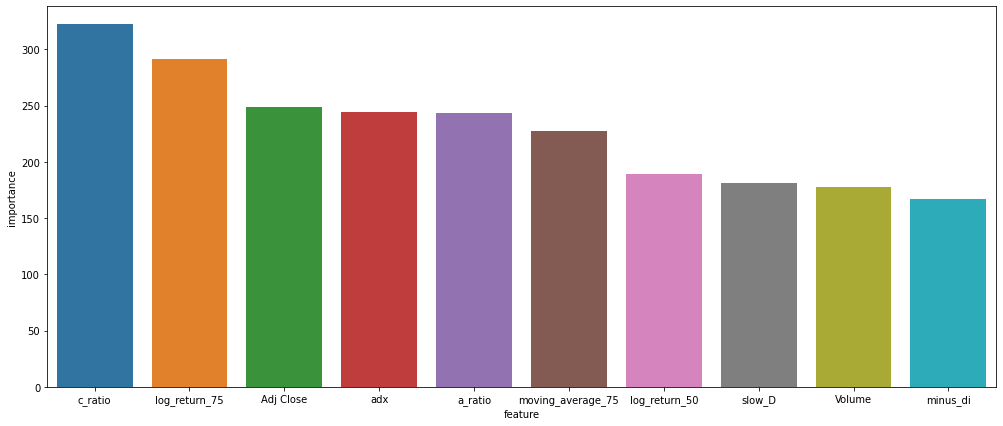

In [49]:
trial = study.best_trial
params = {
        "objective": "multiclass",
        "num_class": 3,
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 777,
    }
params.update(dict(trial.params.items()))

lgb_best_model = lgb.LGBMClassifier(**params)
lgb_best_model.fit(x_train_val, y_train_val)
y_pred = lgb_best_model.predict(x_test, num_iteration=lgb_best_model.best_iteration_)

feature_importance_df = pd.DataFrame({'feature': x_test.columns, 'importance': lgb_best_model.feature_importances_})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
plt.figure(figsize=(17, 7))
sns.barplot(y=feature_importance_df['importance'].iloc[:10], x=feature_importance_df['feature'].iloc[:10])
backtest(stock_data_9613, y_pred, y_test)

## Random Forest

In [ ]:
from sklearn.metrics import make_scorer
def metric_precision_rf(y_true, y_pred):
    matrix = confusion_matrix(y_pred, y_true)
    if (np.sum(matrix[1]) + np.sum(matrix[2])) == 0:
      precision = 0
    elif (np.sum(matrix[1]) + np.sum(matrix[2])) == 1:
      precision = 0.0001
    else:
      precision = (matrix[1][1] + matrix[2][2]) / (np.sum(matrix[1]) + np.sum(matrix[2]))
    print(matrix)
    return precision

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 500)
    max_depth = int(trial.suggest_loguniform('max_depth', 1, 200))
    
    rf_optuna_model = sklearn.ensemble.RandomForestClassifier(n_estimators=n_estimators, 
                                                              max_depth=max_depth,
                                                              random_state=777,
                                                              n_jobs=-1)
    
    score = sklearn.model_selection.cross_validate(rf_optuna_model, 
                                                   x_train_val, 
                                                   y_train_val, 
                                                   cv=5,
                                                   scoring=make_scorer(metric_precision_rf))
    
    print(np.mean(score['test_score']))
    return np.mean(score['test_score'])

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=100)

trial = study.best_trial

[I 2020-11-12 14:11:35,973] A new study created in memory with name: no-name-22d79e82-d5d2-41b2-a020-258cf97cdbb9


[[260  68  49]
 [ 14   6   0]
 [  0   0   0]]
[[273  75  49]
 [  0   0   0]
 [  0   0   0]]
[[273  74  50]
 [  0   0   0]
 [  0   0   0]]
[[273  74  50]
 [  0   0   0]
 [  0   0   0]]


[I 2020-11-12 14:11:43,186] Trial 0 finished with value: 0.06 and parameters: {'n_estimators': 485, 'max_depth': 2.5826665315576967}. Best is trial 0 with value: 0.06.


[[273  74  50]
 [  0   0   0]
 [  0   0   0]]
0.06
[[133  27  44]
 [ 65  26   0]
 [ 76  21   5]]
[[199  61  35]
 [ 35  12   0]
 [ 39   2  14]]
[[262  73  50]
 [ 10   1   0]
 [  1   0   0]]
[[260  71  50]
 [  7   3   0]
 [  6   0   0]]


[I 2020-11-12 14:11:50,361] Trial 1 finished with value: 0.1808008229198415 and parameters: {'n_estimators': 211, 'max_depth': 16.822222776096346}. Best is trial 1 with value: 0.1808008229198415.


[[156  56  15]
 [  1   2   0]
 [116  16  35]]
0.1808008229198415
[[133  30  44]
 [ 64  25   0]
 [ 77  19   5]]
[[189  60  34]
 [ 41  13   1]
 [ 43   2  14]]
[[255  73  49]
 [ 12   1   0]
 [  6   0   1]]
[[258  69  50]
 [  9   5   0]
 [  6   0   0]]


[I 2020-11-12 14:11:54,914] Trial 2 finished with value: 0.19125506072874493 and parameters: {'n_estimators': 124, 'max_depth': 34.43841927964868}. Best is trial 2 with value: 0.19125506072874493.


[[161  60  20]
 [  1   3   0]
 [111  11  30]]
0.19125506072874493
[[172  43  49]
 [ 48  19   0]
 [ 54  12   0]]
[[218  64  43]
 [ 15   9   0]
 [ 40   2   6]]
[[272  74  50]
 [  1   0   0]
 [  0   0   0]]
[[262  74  50]
 [  4   0   0]
 [  7   0   0]]


[I 2020-11-12 14:11:57,738] Trial 3 finished with value: 0.11641194139194137 and parameters: {'n_estimators': 82, 'max_depth': 8.189680314453806}. Best is trial 2 with value: 0.19125506072874493.


[[205  71  30]
 [  1   1   0]
 [ 67   2  20]]
0.11641194139194137
[[264  72  49]
 [ 10   2   0]
 [  0   0   0]]
[[273  75  49]
 [  0   0   0]
 [  0   0   0]]
[[273  74  50]
 [  0   0   0]
 [  0   0   0]]
[[273  74  50]
 [  0   0   0]
 [  0   0   0]]


[I 2020-11-12 14:12:00,877] Trial 4 finished with value: 0.03333333333333333 and parameters: {'n_estimators': 193, 'max_depth': 2.263043028403414}. Best is trial 2 with value: 0.19125506072874493.


[[273  74  50]
 [  0   0   0]
 [  0   0   0]]
0.03333333333333333
[[274  74  49]
 [  0   0   0]
 [  0   0   0]]
[[273  75  49]
 [  0   0   0]
 [  0   0   0]]
[[273  74  50]
 [  0   0   0]
 [  0   0   0]]
[[273  74  50]
 [  0   0   0]
 [  0   0   0]]


[I 2020-11-12 14:12:06,739] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 445, 'max_depth': 1.640818767272552}. Best is trial 2 with value: 0.19125506072874493.


[[273  74  50]
 [  0   0   0]
 [  0   0   0]]
0.0
[[121  28  45]
 [ 75  25   0]
 [ 78  21   4]]
[[193  61  33]
 [ 38  12   0]
 [ 42   2  16]]
[[258  73  49]
 [  9   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:12:19,318] Trial 6 finished with value: 0.1989536121034218 and parameters: {'n_estimators': 361, 'max_depth': 166.03643326168495}. Best is trial 6 with value: 0.1989536121034218.


[[163  58  19]
 [  0   3   0]
 [110  13  31]]
0.1989536121034218
[[211  54  49]
 [ 38  13   0]
 [ 25   7   0]]
[[251  74  45]
 [  0   0   0]
 [ 22   1   4]]
[[273  74  50]
 [  0   0   0]
 [  0   0   0]]
[[268  74  50]
 [  2   0   0]
 [  3   0   0]]


[I 2020-11-12 14:12:21,788] Trial 7 finished with value: 0.1023342411792765 and parameters: {'n_estimators': 95, 'max_depth': 5.367701404938106}. Best is trial 6 with value: 0.1989536121034218.


[[250  74  44]
 [  0   0   0]
 [ 23   0   6]]
0.1023342411792765
[[238  61  49]
 [ 36  13   0]
 [  0   0   0]]
[[263  75  48]
 [  0   0   0]
 [ 10   0   1]]
[[273  74  50]
 [  0   0   0]
 [  0   0   0]]
[[271  74  50]
 [  0   0   0]
 [  2   0   0]]


[I 2020-11-12 14:12:26,681] Trial 8 finished with value: 0.0712430426716141 and parameters: {'n_estimators': 250, 'max_depth': 4.471069422712522}. Best is trial 6 with value: 0.1989536121034218.


[[271  74  50]
 [  0   0   0]
 [  2   0   0]]
0.0712430426716141
[[120  29  44]
 [ 73  25   0]
 [ 81  20   5]]
[[191  61  34]
 [ 40  12   1]
 [ 42   2  14]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:12:38,120] Trial 9 finished with value: 0.19486241272231983 and parameters: {'n_estimators': 329, 'max_depth': 24.74846895922768}. Best is trial 6 with value: 0.1989536121034218.


[[162  58  17]
 [  0   2   0]
 [111  14  33]]
0.19486241272231983
[[122  28  45]
 [ 74  25   0]
 [ 78  21   4]]
[[194  61  33]
 [ 37  12   0]
 [ 42   2  16]]
[[258  73  49]
 [  9   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:12:50,746] Trial 10 finished with value: 0.19928798347173818 and parameters: {'n_estimators': 364, 'max_depth': 194.21709498878485}. Best is trial 10 with value: 0.19928798347173818.


[[162  58  19]
 [  0   3   0]
 [111  13  31]]
0.19928798347173818
[[121  28  44]
 [ 75  25   0]
 [ 78  21   5]]
[[194  61  33]
 [ 37  12   0]
 [ 42   2  16]]
[[258  73  49]
 [  9   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:13:03,886] Trial 11 finished with value: 0.20026100411777553 and parameters: {'n_estimators': 377, 'max_depth': 194.32755466905905}. Best is trial 11 with value: 0.20026100411777553.


[[163  58  19]
 [  0   3   0]
 [110  13  31]]
0.20026100411777553
[[121  28  44]
 [ 75  25   0]
 [ 78  21   5]]
[[194  61  33]
 [ 37  12   0]
 [ 42   2  16]]
[[258  73  49]
 [  9   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:13:17,026] Trial 12 finished with value: 0.20026100411777553 and parameters: {'n_estimators': 376, 'max_depth': 199.05665751615976}. Best is trial 11 with value: 0.20026100411777553.


[[163  58  19]
 [  0   3   0]
 [110  13  31]]
0.20026100411777553
[[120  28  43]
 [ 77  25   0]
 [ 77  21   6]]
[[193  61  33]
 [ 38  12   0]
 [ 42   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:13:31,455] Trial 13 finished with value: 0.19169800218710273 and parameters: {'n_estimators': 425, 'max_depth': 68.18596161872676}. Best is trial 11 with value: 0.20026100411777553.


[[163  58  17]
 [  0   2   0]
 [110  14  33]]
0.19169800218710273
[[125  28  44]
 [ 71  25   0]
 [ 78  21   5]]
[[192  61  33]
 [ 38  12   0]
 [ 43   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:13:42,559] Trial 14 finished with value: 0.1978042516200411 and parameters: {'n_estimators': 324, 'max_depth': 87.90776066459081}. Best is trial 11 with value: 0.20026100411777553.


[[161  58  18]
 [  0   2   0]
 [112  14  32]]
0.1978042516200411
[[121  28  43]
 [ 76  25   0]
 [ 77  21   6]]
[[192  61  33]
 [ 39  12   0]
 [ 42   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:13:57,004] Trial 15 finished with value: 0.19166481702449595 and parameters: {'n_estimators': 428, 'max_depth': 96.7406482739312}. Best is trial 11 with value: 0.20026100411777553.


[[163  59  17]
 [  0   2   0]
 [110  13  33]]
0.19166481702449595
[[124  27  45]
 [ 73  26   0]
 [ 77  21   4]]
[[194  61  33]
 [ 37  12   0]
 [ 42   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:14:06,548] Trial 16 finished with value: 0.1906608553217985 and parameters: {'n_estimators': 277, 'max_depth': 46.97761925792293}. Best is trial 11 with value: 0.20026100411777553.


[[161  59  18]
 [  0   2   0]
 [112  13  32]]
0.1906608553217985
[[125  29  44]
 [ 74  24   0]
 [ 75  21   5]]
[[191  61  33]
 [ 40  12   0]
 [ 42   2  16]]
[[258  73  49]
 [ 10   1   0]
 [  5   0   1]]
[[259  70  50]
 [  7   4   0]
 [  7   0   0]]


[I 2020-11-12 14:14:23,181] Trial 17 finished with value: 0.1905978457219316 and parameters: {'n_estimators': 495, 'max_depth': 163.25601318573905}. Best is trial 11 with value: 0.20026100411777553.


[[160  59  17]
 [  0   2   0]
 [113  13  33]]
0.1905978457219316
[[120  28  44]
 [ 74  25   0]
 [ 80  21   5]]
[[193  61  33]
 [ 38  12   0]
 [ 42   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:14:36,450] Trial 18 finished with value: 0.19779848035909264 and parameters: {'n_estimators': 388, 'max_depth': 118.54114999865587}. Best is trial 11 with value: 0.20026100411777553.


[[161  58  19]
 [  0   3   0]
 [112  13  31]]
0.19779848035909264
[[167  43  39]
 [ 78  25   4]
 [ 29   6   6]]
[[173  60  33]
 [ 62  12  11]
 [ 38   3   5]]
[[254  73  47]
 [ 11   1   0]
 [  8   0   3]]


[I 2020-11-12 14:14:37,334] Trial 19 finished with value: 0.16680395679278526 and parameters: {'n_estimators': 8, 'max_depth': 47.07445894712671}. Best is trial 11 with value: 0.20026100411777553.


[[259  72  50]
 [  6   2   0]
 [  8   0   0]]
[[199  69  32]
 [  2   1   0]
 [ 72   4  18]]
0.16680395679278526
[[274  74  49]
 [  0   0   0]
 [  0   0   0]]
[[273  75  49]
 [  0   0   0]
 [  0   0   0]]
[[273  74  50]
 [  0   0   0]
 [  0   0   0]]
[[273  74  50]
 [  0   0   0]
 [  0   0   0]]


[I 2020-11-12 14:14:41,313] Trial 20 finished with value: 0.0 and parameters: {'n_estimators': 285, 'max_depth': 1.0352641268471556}. Best is trial 11 with value: 0.20026100411777553.


[[273  74  50]
 [  0   0   0]
 [  0   0   0]]
0.0
[[121  28  44]
 [ 75  25   0]
 [ 78  21   5]]
[[194  61  33]
 [ 37  12   0]
 [ 42   2  16]]
[[258  73  49]
 [  9   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:14:54,528] Trial 21 finished with value: 0.20026100411777553 and parameters: {'n_estimators': 377, 'max_depth': 170.25752759429506}. Best is trial 11 with value: 0.20026100411777553.


[[163  58  19]
 [  0   3   0]
 [110  13  31]]
0.20026100411777553
[[122  28  44]
 [ 76  25   0]
 [ 76  21   5]]
[[193  61  33]
 [ 38  12   0]
 [ 42   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:15:08,383] Trial 22 finished with value: 0.19990552958613345 and parameters: {'n_estimators': 402, 'max_depth': 186.106987288978}. Best is trial 11 with value: 0.20026100411777553.


[[164  58  18]
 [  0   3   0]
 [109  13  32]]
0.19990552958613345
[[123  29  43]
 [ 75  24   0]
 [ 76  21   6]]
[[190  61  33]
 [ 41  12   0]
 [ 42   2  16]]
[[259  73  49]
 [  9   1   0]
 [  5   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:15:24,102] Trial 23 finished with value: 0.19164972214144155 and parameters: {'n_estimators': 466, 'max_depth': 121.38568087275296}. Best is trial 11 with value: 0.20026100411777553.


[[160  57  17]
 [  0   2   0]
 [113  15  33]]
0.19164972214144155
[[125  28  45]
 [ 71  25   0]
 [ 78  21   4]]
[[192  61  33]
 [ 38  12   0]
 [ 43   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:15:35,149] Trial 24 finished with value: 0.19748795494680146 and parameters: {'n_estimators': 323, 'max_depth': 62.34030457107148}. Best is trial 11 with value: 0.20026100411777553.


[[163  58  18]
 [  0   2   0]
 [110  14  32]]
0.19748795494680146
[[121  28  44]
 [ 75  25   0]
 [ 78  21   5]]
[[194  61  33]
 [ 37  12   0]
 [ 42   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:15:48,321] Trial 25 finished with value: 0.19895381457529182 and parameters: {'n_estimators': 378, 'max_depth': 179.69556644143262}. Best is trial 11 with value: 0.20026100411777553.


[[163  58  19]
 [  0   3   0]
 [110  13  31]]
0.19895381457529182
[[123  28  45]
 [ 73  25   0]
 [ 78  21   4]]
[[191  61  33]
 [ 39  12   0]
 [ 43   2  16]]
[[258  73  49]
 [  9   1   0]
 [  6   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:15:59,947] Trial 26 finished with value: 0.18996683250414595 and parameters: {'n_estimators': 336, 'max_depth': 119.59285612320723}. Best is trial 11 with value: 0.20026100411777553.


[[166  59  19]
 [  0   2   0]
 [107  13  31]]
0.18996683250414595
[[124  27  45]
 [ 72  26   0]
 [ 78  21   4]]
[[196  61  33]
 [ 35  12   0]
 [ 42   2  16]]
[[255  73  49]
 [ 12   1   0]
 [  6   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:16:09,486] Trial 27 finished with value: 0.18939893490871626 and parameters: {'n_estimators': 284, 'max_depth': 62.77152692409458}. Best is trial 11 with value: 0.20026100411777553.


[[161  59  18]
 [  0   2   0]
 [112  13  32]]
0.18939893490871626
[[121  28  45]
 [ 77  25   0]
 [ 76  21   4]]
[[191  61  33]
 [ 40  12   0]
 [ 42   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:16:23,647] Trial 28 finished with value: 0.18855019714892327 and parameters: {'n_estimators': 410, 'max_depth': 25.459163373312894}. Best is trial 11 with value: 0.20026100411777553.


[[163  58  19]
 [  0   3   0]
 [110  13  31]]
0.18855019714892327
[[125  29  44]
 [ 74  24   0]
 [ 75  21   5]]
[[191  61  33]
 [ 40  12   0]
 [ 42   2  16]]
[[258  73  49]
 [ 10   1   0]
 [  5   0   1]]
[[259  70  50]
 [  7   4   0]
 [  7   0   0]]


[I 2020-11-12 14:16:40,325] Trial 29 finished with value: 0.1905978457219316 and parameters: {'n_estimators': 495, 'max_depth': 133.62136026841839}. Best is trial 11 with value: 0.20026100411777553.


[[160  59  17]
 [  0   2   0]
 [113  13  33]]
0.1905978457219316
[[122  29  44]
 [ 76  24   0]
 [ 76  21   5]]
[[189  61  33]
 [ 42  12   0]
 [ 42   2  16]]
[[259  73  49]
 [  9   1   0]
 [  5   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:16:55,721] Trial 30 finished with value: 0.19075838361868222 and parameters: {'n_estimators': 454, 'max_depth': 198.4733213838752}. Best is trial 11 with value: 0.20026100411777553.


[[162  57  17]
 [  0   2   0]
 [111  15  33]]
0.19075838361868222
[[123  28  44]
 [ 75  25   0]
 [ 76  21   5]]
[[193  61  33]
 [ 38  12   0]
 [ 42   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:17:09,533] Trial 31 finished with value: 0.20005184963685774 and parameters: {'n_estimators': 399, 'max_depth': 87.6938321595999}. Best is trial 11 with value: 0.20026100411777553.


[[164  58  18]
 [  0   3   0]
 [109  13  32]]
0.20005184963685774
[[122  28  45]
 [ 75  25   0]
 [ 77  21   4]]
[[194  61  33]
 [ 37  12   0]
 [ 42   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:17:21,998] Trial 32 finished with value: 0.19725051155340248 and parameters: {'n_estimators': 358, 'max_depth': 84.94470732890261}. Best is trial 11 with value: 0.20026100411777553.


[[163  59  19]
 [  0   2   0]
 [110  13  31]]
0.19725051155340248
[[123  29  43]
 [ 75  24   0]
 [ 76  21   6]]
[[190  61  33]
 [ 41  12   0]
 [ 42   2  16]]
[[258  73  49]
 [ 10   1   0]
 [  5   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:17:38,086] Trial 33 finished with value: 0.1904442251732837 and parameters: {'n_estimators': 469, 'max_depth': 198.931363417267}. Best is trial 11 with value: 0.20026100411777553.


[[161  57  17]
 [  0   2   0]
 [112  15  33]]
0.1904442251732837
[[128  28  45]
 [ 67  26   0]
 [ 79  20   4]]
[[196  60  33]
 [ 35  13   0]
 [ 42   2  16]]
[[258  73  49]
 [  9   1   0]
 [  6   0   1]]
[[258  70  50]
 [  9   4   0]
 [  6   0   0]]


[I 2020-11-12 14:17:45,318] Trial 34 finished with value: 0.19230356470073412 and parameters: {'n_estimators': 203, 'max_depth': 140.06882673351706}. Best is trial 11 with value: 0.20026100411777553.


[[154  57  16]
 [  0   2   0]
 [119  15  34]]
0.19230356470073412
[[126  27  42]
 [ 69  26   0]
 [ 79  21   7]]
[[190  62  33]
 [ 41  12   0]
 [ 42   1  16]]
[[255  73  49]
 [ 12   1   0]
 [  6   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:17:54,064] Trial 35 finished with value: 0.18862714573344128 and parameters: {'n_estimators': 248, 'max_depth': 42.211451287509455}. Best is trial 11 with value: 0.20026100411777553.


[[160  59  19]
 [  0   2   0]
 [113  13  31]]
0.18862714573344128
[[140  33  46]
 [ 66  20   0]
 [ 68  21   3]]
[[203  63  35]
 [ 29  11   0]
 [ 41   1  14]]
[[270  73  50]
 [  3   1   0]
 [  0   0   0]]
[[260  74  50]
 [  8   0   0]
 [  5   0   0]]


[I 2020-11-12 14:18:06,446] Trial 36 finished with value: 0.17755009011292278 and parameters: {'n_estimators': 401, 'max_depth': 12.998146294599433}. Best is trial 11 with value: 0.20026100411777553.


[[183  62  19]
 [  0   2   0]
 [ 90  10  31]]
0.17755009011292278
[[122  27  45]
 [ 73  26   0]
 [ 79  21   4]]
[[190  61  33]
 [ 40  12   0]
 [ 43   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:18:16,859] Trial 37 finished with value: 0.1947087142805306 and parameters: {'n_estimators': 306, 'max_depth': 89.74773321169879}. Best is trial 11 with value: 0.20026100411777553.


[[158  58  19]
 [  0   2   0]
 [115  14  31]]
0.1947087142805306
[[122  28  43]
 [ 75  25   0]
 [ 77  21   6]]
[[192  61  33]
 [ 39  12   0]
 [ 42   2  16]]
[[259  73  49]
 [  9   1   0]
 [  5   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:18:31,871] Trial 38 finished with value: 0.1933250264411843 and parameters: {'n_estimators': 437, 'max_depth': 108.42523008061961}. Best is trial 11 with value: 0.20026100411777553.


[[163  58  18]
 [  0   2   0]
 [110  14  32]]
0.1933250264411843
[[123  28  44]
 [ 74  25   0]
 [ 77  21   5]]
[[193  61  33]
 [ 38  12   0]
 [ 42   2  16]]
[[258  73  49]
 [  9   1   0]
 [  6   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:18:44,236] Trial 39 finished with value: 0.19116656257656126 and parameters: {'n_estimators': 347, 'max_depth': 153.50400599755665}. Best is trial 11 with value: 0.20026100411777553.


[[164  59  19]
 [  0   2   0]
 [109  13  31]]
0.19116656257656126
[[122  28  44]
 [ 74  25   0]
 [ 78  21   5]]
[[193  61  33]
 [ 38  12   0]
 [ 42   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:18:57,744] Trial 40 finished with value: 0.19890928591473053 and parameters: {'n_estimators': 393, 'max_depth': 70.71922238207904}. Best is trial 11 with value: 0.20026100411777553.


[[164  58  19]
 [  0   3   0]
 [109  13  31]]
0.19890928591473053
[[121  28  44]
 [ 75  25   0]
 [ 78  21   5]]
[[194  61  33]
 [ 37  12   0]
 [ 42   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:19:10,957] Trial 41 finished with value: 0.19895381457529182 and parameters: {'n_estimators': 378, 'max_depth': 196.1522078604174}. Best is trial 11 with value: 0.20026100411777553.


[[163  58  19]
 [  0   3   0]
 [110  13  31]]
0.19895381457529182
[[121  28  44]
 [ 76  25   0]
 [ 77  21   5]]
[[193  61  33]
 [ 38  12   0]
 [ 42   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:19:25,046] Trial 42 finished with value: 0.19129131974999436 and parameters: {'n_estimators': 417, 'max_depth': 152.01996843623323}. Best is trial 11 with value: 0.20026100411777553.


[[163  59  17]
 [  0   2   0]
 [110  13  33]]
0.19129131974999436
[[139  35  46]
 [ 65  19   0]
 [ 70  20   3]]
[[208  64  34]
 [ 26  10   0]
 [ 39   1  15]]
[[271  74  50]
 [  2   0   0]
 [  0   0   0]]
[[262  74  50]
 [  5   0   0]
 [  6   0   0]]


[I 2020-11-12 14:19:36,093] Trial 43 finished with value: 0.13023859461589748 and parameters: {'n_estimators': 366, 'max_depth': 11.564917316740262}. Best is trial 11 with value: 0.20026100411777553.


[[194  65  23]
 [  0   2   0]
 [ 79   7  27]]
0.13023859461589748
[[122  28  43]
 [ 75  25   0]
 [ 77  21   6]]
[[190  61  33]
 [ 41  12   0]
 [ 42   2  16]]
[[259  73  49]
 [  9   1   0]
 [  5   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:19:51,136] Trial 44 finished with value: 0.1926039999742932 and parameters: {'n_estimators': 448, 'max_depth': 192.95051659869537}. Best is trial 11 with value: 0.20026100411777553.


[[161  57  17]
 [  0   2   0]
 [112  15  33]]
0.1926039999742932
[[122  27  45]
 [ 73  26   0]
 [ 79  21   4]]
[[190  61  33]
 [ 40  12   0]
 [ 43   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:20:01,727] Trial 45 finished with value: 0.18724425367101222 and parameters: {'n_estimators': 308, 'max_depth': 145.4791506231166}. Best is trial 11 with value: 0.20026100411777553.


[[157  58  18]
 [  0   2   0]
 [116  14  32]]
0.18724425367101222
[[135  30  45]
 [ 66  26   0]
 [ 73  18   4]]
[[190  59  34]
 [ 41  13   1]
 [ 42   3  14]]
[[255  73  49]
 [ 12   1   0]
 [  6   0   1]]
[[258  69  50]
 [  8   5   0]
 [  7   0   0]]


[I 2020-11-12 14:20:07,328] Trial 46 finished with value: 0.19473700141788233 and parameters: {'n_estimators': 149, 'max_depth': 24.77229047824038}. Best is trial 11 with value: 0.20026100411777553.


[[161  60  17]
 [  0   3   0]
 [112  11  33]]
0.19473700141788233
[[232  59  49]
 [ 42  15   0]
 [  0   0   0]]
[[268  75  49]
 [  0   0   0]
 [  5   0   0]]
[[273  74  50]
 [  0   0   0]
 [  0   0   0]]
[[272  74  50]
 [  0   0   0]
 [  1   0   0]]


[I 2020-11-12 14:20:15,485] Trial 47 finished with value: 0.05265157894736842 and parameters: {'n_estimators': 405, 'max_depth': 4.316017399079412}. Best is trial 11 with value: 0.20026100411777553.


[[271  74  50]
 [  0   0   0]
 [  2   0   0]]
0.05265157894736842
[[123  29  43]
 [ 74  24   0]
 [ 77  21   6]]
[[191  61  33]
 [ 40  12   0]
 [ 42   2  16]]
[[258  73  49]
 [ 10   1   0]
 [  5   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:20:31,542] Trial 48 finished with value: 0.19142682650618004 and parameters: {'n_estimators': 482, 'max_depth': 76.9718281950634}. Best is trial 11 with value: 0.20026100411777553.


[[161  59  17]
 [  0   2   0]
 [112  13  33]]
0.19142682650618004
[[120  28  44]
 [ 77  25   0]
 [ 77  21   5]]
[[193  61  33]
 [ 38  12   0]
 [ 42   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:20:45,929] Trial 49 finished with value: 0.19143003751983093 and parameters: {'n_estimators': 422, 'max_depth': 106.01316087883686}. Best is trial 11 with value: 0.20026100411777553.


[[164  59  17]
 [  0   2   0]
 [109  13  33]]
0.19143003751983093
[[125  28  44]
 [ 73  25   0]
 [ 76  21   5]]
[[192  61  33]
 [ 40  12   0]
 [ 41   2  16]]
[[258  73  49]
 [  9   1   0]
 [  6   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:20:58,165] Trial 50 finished with value: 0.19156156156156157 and parameters: {'n_estimators': 346, 'max_depth': 33.91457607156457}. Best is trial 11 with value: 0.20026100411777553.


[[166  59  19]
 [  0   2   0]
 [107  13  31]]
0.19156156156156157
[[120  28  44]
 [ 75  25   0]
 [ 79  21   5]]
[[194  61  33]
 [ 37  12   0]
 [ 42   2  16]]
[[258  73  49]
 [  9   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:21:11,068] Trial 51 finished with value: 0.20083058741669638 and parameters: {'n_estimators': 369, 'max_depth': 198.49188933100064}. Best is trial 51 with value: 0.20083058741669638.


[[162  58  18]
 [  0   3   0]
 [111  13  32]]
0.20083058741669638
[[121  28  44]
 [ 75  25   0]
 [ 78  21   5]]
[[194  61  33]
 [ 37  12   0]
 [ 42   2  16]]
[[258  73  49]
 [  9   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:21:24,358] Trial 52 finished with value: 0.20026100411777553 and parameters: {'n_estimators': 377, 'max_depth': 174.0875893637626}. Best is trial 51 with value: 0.20083058741669638.


[[163  58  19]
 [  0   3   0]
 [110  13  31]]
0.20026100411777553
[[121  28  44]
 [ 75  25   0]
 [ 78  21   5]]
[[194  61  33]
 [ 37  12   0]
 [ 42   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:21:37,427] Trial 53 finished with value: 0.19994551013281822 and parameters: {'n_estimators': 374, 'max_depth': 161.25553599521348}. Best is trial 51 with value: 0.20083058741669638.


[[163  58  18]
 [  0   3   0]
 [110  13  32]]
0.19994551013281822
[[122  27  45]
 [ 73  26   0]
 [ 79  21   4]]
[[190  61  33]
 [ 40  12   0]
 [ 43   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:21:47,980] Trial 54 finished with value: 0.18724425367101222 and parameters: {'n_estimators': 308, 'max_depth': 100.69244938602661}. Best is trial 51 with value: 0.20083058741669638.


[[157  58  18]
 [  0   2   0]
 [116  14  32]]
0.18724425367101222
[[123  28  44]
 [ 74  25   0]
 [ 77  21   5]]
[[193  61  33]
 [ 38  12   0]
 [ 42   2  16]]
[[258  73  49]
 [  9   1   0]
 [  6   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:22:00,141] Trial 55 finished with value: 0.19089360972296326 and parameters: {'n_estimators': 351, 'max_depth': 125.6816285326002}. Best is trial 51 with value: 0.20083058741669638.


[[163  59  19]
 [  0   2   0]
 [110  13  31]]
0.19089360972296326
[[121  28  44]
 [ 75  25   0]
 [ 78  21   5]]
[[194  61  33]
 [ 37  12   0]
 [ 42   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:22:13,343] Trial 56 finished with value: 0.19840900826194807 and parameters: {'n_estimators': 386, 'max_depth': 166.78452595759296}. Best is trial 51 with value: 0.20083058741669638.


[[161  58  19]
 [  0   3   0]
 [112  13  31]]
0.19840900826194807
[[128  27  42]
 [ 70  26   0]
 [ 76  21   7]]
[[195  61  33]
 [ 36  12   0]
 [ 42   2  16]]
[[258  73  49]
 [  9   1   0]
 [  6   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:22:21,354] Trial 57 finished with value: 0.19486392462151172 and parameters: {'n_estimators': 233, 'max_depth': 196.5889621567128}. Best is trial 51 with value: 0.20083058741669638.


[[162  59  19]
 [  0   2   0]
 [111  13  31]]
0.19486392462151172
[[124  28  45]
 [ 72  25   0]
 [ 78  21   4]]
[[192  61  33]
 [ 38  12   0]
 [ 43   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:22:32,731] Trial 58 finished with value: 0.19707154721752534 and parameters: {'n_estimators': 327, 'max_depth': 58.043433646755915}. Best is trial 51 with value: 0.20083058741669638.


[[162  58  18]
 [  0   2   0]
 [111  14  32]]
0.19707154721752534
[[121  28  43]
 [ 76  25   0]
 [ 77  21   6]]
[[192  61  33]
 [ 39  12   0]
 [ 42   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:22:47,333] Trial 59 finished with value: 0.19166481702449595 and parameters: {'n_estimators': 428, 'max_depth': 133.03253749568356}. Best is trial 51 with value: 0.20083058741669638.


[[163  59  17]
 [  0   2   0]
 [110  13  33]]
0.19166481702449595
[[120  30  45]
 [ 74  23   0]
 [ 80  21   4]]
[[195  62  34]
 [ 37  11   1]
 [ 41   2  14]]
[[262  73  50]
 [  8   1   0]
 [  3   0   0]]
[[260  69  50]
 [  8   5   0]
 [  5   0   0]]


[I 2020-11-12 14:22:59,776] Trial 60 finished with value: 0.18987470681030366 and parameters: {'n_estimators': 364, 'max_depth': 19.31933182865618}. Best is trial 51 with value: 0.20083058741669638.


[[163  57  17]
 [  0   2   0]
 [110  15  33]]
0.18987470681030366
[[121  28  44]
 [ 75  25   0]
 [ 78  21   5]]
[[194  61  33]
 [ 37  12   0]
 [ 42   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:23:13,026] Trial 61 finished with value: 0.19895381457529182 and parameters: {'n_estimators': 378, 'max_depth': 164.41355960604227}. Best is trial 51 with value: 0.20083058741669638.


[[163  58  19]
 [  0   3   0]
 [110  13  31]]
0.19895381457529182
[[119  28  44]
 [ 76  25   0]
 [ 79  21   5]]
[[194  61  33]
 [ 37  12   0]
 [ 42   2  16]]
[[258  73  49]
 [  9   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:23:26,041] Trial 62 finished with value: 0.20166335109329814 and parameters: {'n_estimators': 371, 'max_depth': 105.032192620062}. Best is trial 62 with value: 0.20166335109329814.


[[162  58  17]
 [  0   3   0]
 [111  13  33]]
0.20166335109329814
[[122  28  44]
 [ 74  25   0]
 [ 78  21   5]]
[[193  61  33]
 [ 38  12   0]
 [ 42   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:23:39,750] Trial 63 finished with value: 0.19863164423581497 and parameters: {'n_estimators': 394, 'max_depth': 95.91385662572061}. Best is trial 62 with value: 0.20166335109329814.


[[163  58  19]
 [  0   3   0]
 [110  13  31]]
0.19863164423581497
[[123  28  44]
 [ 73  25   0]
 [ 78  21   5]]
[[192  61  33]
 [ 38  12   0]
 [ 43   2  16]]
[[258  73  49]
 [  9   1   0]
 [  6   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:23:51,741] Trial 64 finished with value: 0.19126453185859127 and parameters: {'n_estimators': 337, 'max_depth': 81.06780223871887}. Best is trial 62 with value: 0.20166335109329814.


[[166  59  19]
 [  0   2   0]
 [107  13  31]]
0.19126453185859127
[[123  27  45]
 [ 72  26   0]
 [ 79  21   4]]
[[193  61  33]
 [ 38  12   0]
 [ 42   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:24:01,781] Trial 65 finished with value: 0.18905087977152146 and parameters: {'n_estimators': 293, 'max_depth': 114.27544516937351}. Best is trial 62 with value: 0.20166335109329814.


[[162  58  19]
 [  0   2   0]
 [111  14  31]]
0.18905087977152146
[[126  27  44]
 [ 69  26   0]
 [ 79  21   5]]
[[193  61  33]
 [ 38  12   0]
 [ 42   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:24:10,933] Trial 66 finished with value: 0.19055106621773285 and parameters: {'n_estimators': 265, 'max_depth': 51.48197714316685}. Best is trial 62 with value: 0.20166335109329814.


[[158  59  18]
 [  0   2   0]
 [115  13  32]]
0.19055106621773285
[[122  28  43]
 [ 75  25   0]
 [ 77  21   6]]
[[192  61  33]
 [ 39  12   0]
 [ 42   2  16]]
[[259  73  49]
 [  9   1   0]
 [  5   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:24:26,151] Trial 67 finished with value: 0.1933250264411843 and parameters: {'n_estimators': 437, 'max_depth': 135.94900531953874}. Best is trial 62 with value: 0.20166335109329814.


[[163  58  18]
 [  0   2   0]
 [110  14  32]]
0.1933250264411843
[[122  29  43]
 [ 75  24   0]
 [ 77  21   6]]
[[189  61  33]
 [ 42  12   0]
 [ 42   2  16]]
[[259  73  49]
 [  9   1   0]
 [  5   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:24:41,862] Trial 68 finished with value: 0.1913337782515036 and parameters: {'n_estimators': 456, 'max_depth': 198.0267680083362}. Best is trial 62 with value: 0.20166335109329814.


[[161  57  17]
 [  0   2   0]
 [112  15  33]]
0.1913337782515036
[[124  28  45]
 [ 72  25   0]
 [ 78  21   4]]
[[192  61  33]
 [ 38  12   0]
 [ 43   2  16]]
[[256  73  49]
 [ 11   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:24:52,845] Trial 69 finished with value: 0.1959019565742505 and parameters: {'n_estimators': 321, 'max_depth': 173.8633997229816}. Best is trial 62 with value: 0.20166335109329814.


[[162  58  18]
 [  0   2   0]
 [111  14  32]]
0.1959019565742505
[[198  61  34]
 [ 46  10  12]
 [ 30   3   3]]
[[186  59  23]
 [ 78  15  23]
 [  9   1   3]]
[[239  70  46]
 [ 30   3   4]
 [  4   1   0]]


[I 2020-11-12 14:24:53,508] Trial 70 finished with value: 0.16520122588054045 and parameters: {'n_estimators': 2, 'max_depth': 113.09505253288745}. Best is trial 62 with value: 0.20166335109329814.


[[262  66  50]
 [  7   7   0]
 [  4   1   0]]
[[219  62  42]
 [ 10   3   2]
 [ 44   9   6]]
0.16520122588054045
[[120  28  44]
 [ 76  25   0]
 [ 78  21   5]]
[[194  61  33]
 [ 37  12   0]
 [ 42   2  16]]
[[259  73  49]
 [  8   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:25:06,572] Trial 71 finished with value: 0.20257981588764054 and parameters: {'n_estimators': 372, 'max_depth': 155.3397441414988}. Best is trial 71 with value: 0.20257981588764054.


[[163  58  18]
 [  0   3   0]
 [110  13  32]]
0.20257981588764054
[[121  28  44]
 [ 77  25   0]
 [ 76  21   5]]
[[193  61  33]
 [ 38  12   0]
 [ 42   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:25:20,909] Trial 72 finished with value: 0.19157350954278646 and parameters: {'n_estimators': 410, 'max_depth': 136.33755783763291}. Best is trial 71 with value: 0.20257981588764054.


[[164  58  18]
 [  0   3   0]
 [109  13  32]]
0.19157350954278646
[[122  28  44]
 [ 75  25   0]
 [ 77  21   5]]
[[193  61  33]
 [ 38  12   0]
 [ 42   2  16]]
[[258  73  49]
 [  9   1   0]
 [  6   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:25:33,203] Trial 73 finished with value: 0.1904778139250562 and parameters: {'n_estimators': 353, 'max_depth': 92.15135804599998}. Best is trial 71 with value: 0.20257981588764054.


[[163  58  19]
 [  0   2   0]
 [110  14  31]]
0.1904778139250562
[[121  28  44]
 [ 75  25   0]
 [ 78  21   5]]
[[193  61  33]
 [ 38  12   0]
 [ 42   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:25:46,667] Trial 74 finished with value: 0.19848675869539192 and parameters: {'n_estimators': 392, 'max_depth': 172.5135828604303}. Best is trial 71 with value: 0.20257981588764054.


[[163  58  19]
 [  0   3   0]
 [110  13  31]]
0.19848675869539192
[[120  28  44]
 [ 75  25   0]
 [ 79  21   5]]
[[194  61  33]
 [ 37  12   0]
 [ 42   2  16]]
[[258  73  49]
 [  9   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:25:59,490] Trial 75 finished with value: 0.20110922765234643 and parameters: {'n_estimators': 368, 'max_depth': 120.80943221134834}. Best is trial 71 with value: 0.20257981588764054.


[[163  58  18]
 [  0   3   0]
 [110  13  32]]
0.20110922765234643
[[119  28  44]
 [ 76  25   0]
 [ 79  21   5]]
[[194  61  33]
 [ 37  12   0]
 [ 42   2  16]]
[[258  73  49]
 [  9   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:26:12,449] Trial 76 finished with value: 0.20166335109329814 and parameters: {'n_estimators': 371, 'max_depth': 146.93045512847195}. Best is trial 71 with value: 0.20257981588764054.


[[162  58  17]
 [  0   3   0]
 [111  13  33]]
0.20166335109329814
[[121  28  44]
 [ 75  25   0]
 [ 78  21   5]]
[[194  61  33]
 [ 37  12   0]
 [ 42   2  16]]
[[258  73  49]
 [  9   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:26:25,151] Trial 77 finished with value: 0.2009740594396519 and parameters: {'n_estimators': 365, 'max_depth': 148.031984026249}. Best is trial 71 with value: 0.20257981588764054.


[[162  58  18]
 [  0   3   0]
 [111  13  32]]
0.2009740594396519
[[123  28  45]
 [ 73  25   0]
 [ 78  21   4]]
[[191  61  33]
 [ 39  12   0]
 [ 43   2  16]]
[[258  73  49]
 [  9   1   0]
 [  6   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:26:37,024] Trial 78 finished with value: 0.18996683250414595 and parameters: {'n_estimators': 336, 'max_depth': 70.08291847672022}. Best is trial 71 with value: 0.20257981588764054.


[[166  59  19]
 [  0   2   0]
 [107  13  31]]
0.18996683250414595
[[121  28  45]
 [ 75  25   0]
 [ 78  21   4]]
[[193  61  33]
 [ 38  12   0]
 [ 42   2  16]]
[[258  73  49]
 [  9   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:26:49,504] Trial 79 finished with value: 0.1989536121034218 and parameters: {'n_estimators': 361, 'max_depth': 121.15164080532765}. Best is trial 71 with value: 0.20257981588764054.


[[163  58  19]
 [  0   3   0]
 [110  13  31]]
0.1989536121034218
[[274  74  49]
 [  0   0   0]
 [  0   0   0]]
[[273  75  49]
 [  0   0   0]
 [  0   0   0]]
[[273  74  50]
 [  0   0   0]
 [  0   0   0]]
[[273  74  50]
 [  0   0   0]
 [  0   0   0]]


[I 2020-11-12 14:26:55,239] Trial 80 finished with value: 0.0 and parameters: {'n_estimators': 413, 'max_depth': 1.5308827932126567}. Best is trial 71 with value: 0.20257981588764054.


[[273  74  50]
 [  0   0   0]
 [  0   0   0]]
0.0
[[119  28  44]
 [ 76  25   0]
 [ 79  21   5]]
[[194  61  33]
 [ 37  12   0]
 [ 42   2  16]]
[[258  73  49]
 [  9   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:27:08,141] Trial 81 finished with value: 0.20166335109329814 and parameters: {'n_estimators': 371, 'max_depth': 150.1251583050939}. Best is trial 71 with value: 0.20257981588764054.


[[162  58  17]
 [  0   3   0]
 [111  13  33]]
0.20166335109329814
[[119  28  44]
 [ 76  25   0]
 [ 79  21   5]]
[[194  61  33]
 [ 37  12   0]
 [ 42   2  16]]
[[258  73  49]
 [  9   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:27:21,049] Trial 82 finished with value: 0.20166335109329814 and parameters: {'n_estimators': 371, 'max_depth': 146.54855570132207}. Best is trial 71 with value: 0.20257981588764054.


[[162  58  17]
 [  0   3   0]
 [111  13  33]]
0.20166335109329814
[[124  28  44]
 [ 74  25   0]
 [ 76  21   5]]
[[192  61  33]
 [ 39  12   0]
 [ 42   2  16]]
[[258  73  49]
 [  9   1   0]
 [  6   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:27:33,272] Trial 83 finished with value: 0.1918647965180011 and parameters: {'n_estimators': 343, 'max_depth': 145.06579716148713}. Best is trial 71 with value: 0.20257981588764054.


[[164  59  18]
 [  0   2   0]
 [109  13  32]]
0.1918647965180011
[[121  28  45]
 [ 75  25   0]
 [ 78  21   4]]
[[193  61  33]
 [ 38  12   0]
 [ 42   2  16]]
[[258  73  49]
 [  9   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:27:45,804] Trial 84 finished with value: 0.1989536121034218 and parameters: {'n_estimators': 361, 'max_depth': 108.3312599850632}. Best is trial 71 with value: 0.20257981588764054.


[[163  58  19]
 [  0   3   0]
 [110  13  31]]
0.1989536121034218
[[123  28  45]
 [ 73  25   0]
 [ 78  21   4]]
[[191  61  33]
 [ 39  12   0]
 [ 43   2  16]]
[[256  73  49]
 [ 11   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:27:56,859] Trial 85 finished with value: 0.1950399319193506 and parameters: {'n_estimators': 314, 'max_depth': 151.1473661686092}. Best is trial 71 with value: 0.20257981588764054.


[[161  58  18]
 [  0   2   0]
 [112  14  32]]
0.1950399319193506
[[120  28  44]
 [ 75  25   0]
 [ 79  21   5]]
[[194  61  33]
 [ 37  12   0]
 [ 42   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:28:09,825] Trial 86 finished with value: 0.20049824064150829 and parameters: {'n_estimators': 370, 'max_depth': 97.21488904893309}. Best is trial 71 with value: 0.20257981588764054.


[[162  58  17]
 [  0   3   0]
 [111  13  33]]
0.20049824064150829
[[120  28  44]
 [ 74  25   0]
 [ 80  21   5]]
[[193  61  33]
 [ 38  12   0]
 [ 42   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:28:23,234] Trial 87 finished with value: 0.19779848035909264 and parameters: {'n_estimators': 388, 'max_depth': 80.52221404366679}. Best is trial 71 with value: 0.20257981588764054.


[[161  58  19]
 [  0   3   0]
 [112  13  31]]
0.19779848035909264
[[120  28  44]
 [ 75  25   0]
 [ 79  21   5]]
[[194  61  33]
 [ 37  12   0]
 [ 42   2  16]]
[[258  73  49]
 [  9   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:28:36,164] Trial 88 finished with value: 0.20110922765234643 and parameters: {'n_estimators': 368, 'max_depth': 100.72591565066739}. Best is trial 71 with value: 0.20257981588764054.


[[163  58  18]
 [  0   3   0]
 [110  13  32]]
0.20110922765234643
[[124  28  44]
 [ 73  25   0]
 [ 77  21   5]]
[[192  61  33]
 [ 38  12   0]
 [ 43   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:28:47,696] Trial 89 finished with value: 0.19819297257224208 and parameters: {'n_estimators': 330, 'max_depth': 125.06929363414042}. Best is trial 71 with value: 0.20257981588764054.


[[163  58  18]
 [  0   2   0]
 [110  14  32]]
0.19819297257224208
[[151  34  44]
 [ 57  23   0]
 [ 66  17   5]]
[[174  59  31]
 [ 52  13   3]
 [ 47   3  15]]
[[255  73  48]
 [ 13   1   1]
 [  5   0   1]]
[[259  69  50]
 [ 10   5   0]
 [  4   0   0]]


[I 2020-11-12 14:28:49,802] Trial 90 finished with value: 0.19125572552069828 and parameters: {'n_estimators': 44, 'max_depth': 76.1368219597411}. Best is trial 71 with value: 0.20257981588764054.


[[169  62  21]
 [  9   3   0]
 [ 95   9  29]]
0.19125572552069828
[[120  28  44]
 [ 75  25   0]
 [ 79  21   5]]
[[194  61  33]
 [ 37  12   0]
 [ 42   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:29:02,847] Trial 91 finished with value: 0.20049824064150829 and parameters: {'n_estimators': 370, 'max_depth': 101.58032074885013}. Best is trial 71 with value: 0.20257981588764054.


[[162  58  17]
 [  0   3   0]
 [111  13  33]]
0.20049824064150829
[[125  28  44]
 [ 74  25   0]
 [ 75  21   5]]
[[193  61  33]
 [ 38  12   0]
 [ 42   2  16]]
[[258  73  49]
 [  9   1   0]
 [  6   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:29:15,167] Trial 92 finished with value: 0.19275391486017673 and parameters: {'n_estimators': 345, 'max_depth': 102.30475941316875}. Best is trial 71 with value: 0.20257981588764054.


[[165  59  18]
 [  0   2   0]
 [108  13  32]]
0.19275391486017673
[[123  27  45]
 [ 73  26   0]
 [ 78  21   4]]
[[191  61  33]
 [ 39  12   0]
 [ 43   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:29:25,294] Trial 93 finished with value: 0.1887938793879388 and parameters: {'n_estimators': 298, 'max_depth': 125.26647412192207}. Best is trial 71 with value: 0.20257981588764054.


[[157  58  17]
 [  0   2   0]
 [116  14  33]]
0.1887938793879388
[[122  28  45]
 [ 74  25   0]
 [ 78  21   4]]
[[193  61  33]
 [ 38  12   0]
 [ 42   2  16]]
[[258  73  49]
 [  9   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:29:37,724] Trial 94 finished with value: 0.19809064521598624 and parameters: {'n_estimators': 356, 'max_depth': 149.57568461088374}. Best is trial 71 with value: 0.20257981588764054.


[[163  59  19]
 [  0   2   0]
 [110  13  31]]
0.19809064521598624
[[121  28  44]
 [ 76  25   0]
 [ 77  21   5]]
[[193  61  33]
 [ 38  12   0]
 [ 42   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:29:51,563] Trial 95 finished with value: 0.1997606440457104 and parameters: {'n_estimators': 400, 'max_depth': 90.92898035096499}. Best is trial 71 with value: 0.20257981588764054.


[[164  58  18]
 [  0   3   0]
 [109  13  32]]
0.1997606440457104
[[122  28  44]
 [ 74  25   0]
 [ 78  21   5]]
[[194  61  33]
 [ 37  12   0]
 [ 42   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:30:04,572] Trial 96 finished with value: 0.19981175543759128 and parameters: {'n_estimators': 382, 'max_depth': 59.71226331565583}. Best is trial 71 with value: 0.20257981588764054.


[[162  58  18]
 [  0   3   0]
 [111  13  32]]
0.19981175543759128
[[120  28  44]
 [ 75  25   0]
 [ 79  21   5]]
[[194  61  33]
 [ 37  12   0]
 [ 42   2  16]]
[[258  73  49]
 [  9   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:30:17,382] Trial 97 finished with value: 0.20083058741669638 and parameters: {'n_estimators': 369, 'max_depth': 114.67005356222607}. Best is trial 71 with value: 0.20257981588764054.


[[162  58  18]
 [  0   3   0]
 [111  13  32]]
0.20083058741669638
[[121  28  44]
 [ 76  25   0]
 [ 77  21   5]]
[[193  61  33]
 [ 38  12   0]
 [ 42   2  16]]
[[257  73  49]
 [ 10   1   0]
 [  6   0   1]]
[[259  70  50]
 [  8   4   0]
 [  6   0   0]]


[I 2020-11-12 14:30:31,470] Trial 98 finished with value: 0.19129131974999436 and parameters: {'n_estimators': 417, 'max_depth': 182.173693407529}. Best is trial 71 with value: 0.20257981588764054.


[[163  59  17]
 [  0   2   0]
 [110  13  33]]
0.19129131974999436
[[122  28  45]
 [ 73  25   0]
 [ 79  21   4]]
[[192  61  33]
 [ 38  12   0]
 [ 43   2  16]]
[[256  73  49]
 [ 11   1   0]
 [  6   0   1]]
[[259  69  50]
 [  8   5   0]
 [  6   0   0]]


[I 2020-11-12 14:30:42,149] Trial 99 finished with value: 0.19588550694743928 and parameters: {'n_estimators': 318, 'max_depth': 113.16735366504209}. Best is trial 71 with value: 0.20257981588764054.


[[163  58  18]
 [  0   2   0]
 [110  14  32]]
0.19588550694743928


{'n_estimators': 372, 'max_depth': 155.3397441414988}
-----my_precision-----
[[165  35  14]
 [  2   0   1]
 [ 17   5   2]]
my_precision: 0.07407407407407407
----------------------
----------------------
trade_count: 1
trend_flag: 1.0
====> loss_price: 7120.0 log_rerutn -5.129329438755057
====> total_return_price: -7120.0 total_log_rerutn -5.129329438755057
----------------------
----------------------
trade_count: 2
trend_flag: 1.0
====> loss_price: 7130.0 log_rerutn -5.129329438755057
====> total_return_price: -14250.0 total_log_rerutn -10.258658877510115
----------------------
----------------------
trade_count: 3
trend_flag: 1.0
====> loss_price: 7215.000000000001 log_rerutn -5.129329438755057
====> total_return_price: -21465.0 total_log_rerutn -15.387988316265172
----------------------
----------------------
trade_count: 4
trend_flag: 2.0
====> return_price: 7030.0 log_rerutn 4.879016416943205
====> total_return_price: -14435.0 total_log_rerutn -10.508971899321967
-----------------

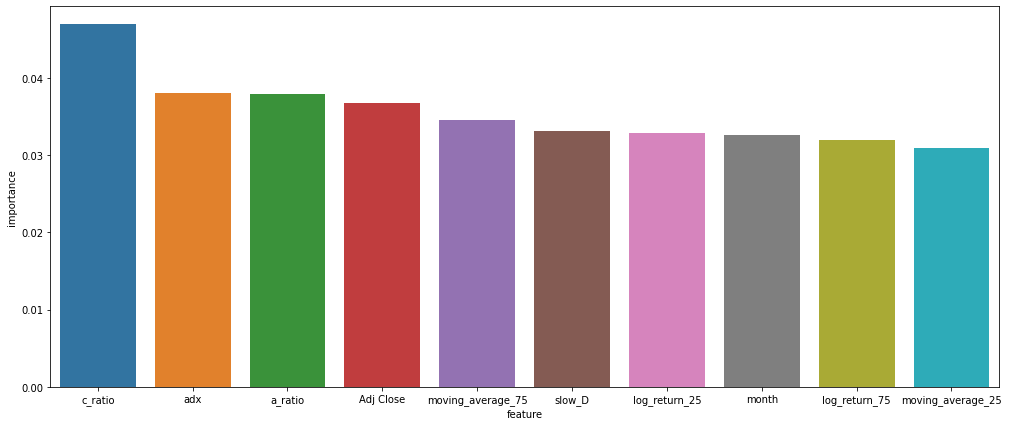

In [ ]:
print(study.best_params)
rf_best_model = sklearn.ensemble.RandomForestClassifier(**study.best_params, random_state=777)
rf_best_model.fit(x_train, y_train)
y_pred = rf_best_model.predict(x_test)

feature_importance_df = pd.DataFrame({'feature': x_test.columns, 'importance': rf_best_model.feature_importances_})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
plt.figure(figsize=(17, 7))
sns.barplot(y=feature_importance_df['importance'].iloc[:10], x=feature_importance_df['feature'].iloc[:10])

backtest(stock_data_9613, y_pred, y_test)

## SGD

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.metrics import make_scorer
def metric_precision_sgd(y_true, y_pred):
    matrix = confusion_matrix(y_pred, y_true)
    if (np.sum(matrix[1]) + np.sum(matrix[2])) == 0:
      precision = 0
    elif (np.sum(matrix[1]) + np.sum(matrix[2])) == 1:
      precision = 0.0001
    else:
      precision = (matrix[1][1] + matrix[2][2]) / (np.sum(matrix[1]) + np.sum(matrix[2]))
#      precision = ((matrix[1][1] + matrix[2][2]) - (matrix[1][2] + matrix[2][1])) / (np.sum(matrix[1]) + np.sum(matrix[2]))
#      if precision < 0:
#        precision = 0
    print('***************')
    print(matrix)
    print(precision)
    print('***************')
    return precision

def objective(trial):
    params = {'penalty': 'elasticnet', 
              'loss': 'log',
              'n_iter_no_change': 100,
              'early_stopping': True,
              'n_jobs': -1,
              'validation_fraction': 0.3,
              'random_state': 1234,
              'alpha': trial.suggest_float("alpha", 0.0001, 0.1),
              'l1_ratio': trial.suggest_float("l1_ratio", 0.1, 1.0, log=True)}

    sgd_optuna_model = make_pipeline(StandardScaler(),
                                     SGDClassifier(**params))

    score = sklearn.model_selection.cross_validate(sgd_optuna_model, 
                                                   x_train_val, 
                                                   y_train_val, 
                                                   cv=5,
                                                   scoring=make_scorer(metric_precision_sgd))
    
    print('=========>', np.mean(score['test_score']))
    return np.mean(score['test_score'])
study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=100)

trial = study.best_trial

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(study.best_params)

params = {'penalty': 'elasticnet', 
          'loss': 'log',
          'n_iter_no_change': 50,
          'early_stopping': True,
          'n_jobs': -1,
          'validation_fraction': 0.3,
          'random_state': 1234}
params.update(dict(trial.params.items()))
sgd_best_model = make_pipeline(StandardScaler(), SGDClassifier(**params))
sgd_best_model.fit(x_train_val, y_train_val)
y_pred = sgd_best_model.predict(x_test)
backtest(stock_data_9613, y_pred, y_test)

{'l1_ratio': 0.127246688063369, 'alpha': 0.003729215194375882, 'tol': 0.004855936354525311}
-----my_precision-----
[[184  40  17]
 [  0   0   0]
 [  0   0   0]]
my_precision: 0
----------------------
